<h1> Creación de Modelos

<h3> Creación de modelos en base a máscaras y a puntos de interés

Equipo de Reto 5

Inteligencia artificial avanzada para la ciencia de datos II (Grupo 502)

30 de noviembre de 2023

### Preparar el entorno de trabajo

In [1]:
# Importar librerias y módulos necesarios
import os
import numpy as np
from keras.layers import Conv2D, Activation, MaxPooling2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.models import load_model
import random
from google.colab.patches import cv2_imshow
import cv2

In [2]:
# Definir el directorio de trabajo actual
os.chdir('/content/drive/Shareddrives/Penta Tech/Reto')

In [3]:
# Definir el directorio con los conjuntos de datos
data_directory = os.path.join(os.getcwd(), 'CompleteDatasets')

In [5]:
# Definir el directorio para guardar los mejores modelos y su historial de entrenamiento
models_directory = os.path.join(os.getcwd(), 'Models')
os.mkdir(models_directory)
logs_directory = os.path.join(os.getcwd(), 'Logs')
os.mkdir(logs_directory)

In [6]:
# Definir dimensiones importantes de los datos
img_height = 112
img_width = 112
img_channels = 1
mask_channels = 1
landmarks_channels = 7

### Definir la arquitectura para un modelo U-Net

In [6]:
# Definir un bloque convolucional
def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding='same')(input)
  x = Activation('relu')(x)
  x = Conv2D(num_filters, 3, padding='same')(x)
  x = Activation('relu')(x)
  return x

In [7]:
# Definir un bloque codificador
def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPooling2D((2,2))(x)
  return x, p

In [8]:
# Definir un bloque decodificador
def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(input)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

In [9]:
# Definir la arquitectura para un modelo U-Net
def build_unet(input_shape, num_clases):
  inputs = Input(input_shape)

  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  b1 = conv_block(p4, 1024)

  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  outputs = Conv2D(num_clases, 1, padding='same', activation='sigmoid')(d4)

  model = Model(inputs, outputs, name='U-Net')
  return model

### Crear y entrenar un modelo U-Net basado en máscaras

In [10]:
# Cargar el conjunto de entrenamiento
train_input = np.load(os.path.join(data_directory, 'train_images.npy'))
train_output = np.load(os.path.join(data_directory, 'train_masks.npy'))
print('Dimensiones del conjunto de entrenamiento:', train_input.shape, train_output.shape)

# Cargar el conjunto de validación
val_input = np.load(os.path.join(data_directory, 'val_images.npy'))
val_output = np.load(os.path.join(data_directory, 'val_masks.npy'))
print('Dimensiones del conjunto de validación   :', val_input.shape, val_output.shape)

Dimensiones del conjunto de entrenamiento: (14912, 112, 112, 1) (14912, 112, 112, 1)
Dimensiones del conjunto de validación   : (2576, 112, 112, 1) (2576, 112, 112, 1)


In [11]:
# Crear y compilar el modelo basado en máscaras
mask_model = build_unet((img_height, img_height, img_channels), mask_channels)
mask_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
# Definir "Callbacks" para guardar los modelos mejor entrenados y el historial de entrenamiento
checkpoint = ModelCheckpoint(os.path.join(models_directory, 'masks_{epoch:02d}_{val_accuracy:.2f}.h5'), monitor='val_accuracy', save_best_only=True, mode='max')
log_csv = CSVLogger(os.path.join(logs_directory, 'MaskModels.csv'), separator=',', append=False)

In [15]:
# Entrenar el modelo con los datos de entrenamiento y validación
mask_model.fit(train_input, train_output,
               validation_data=(val_input, val_output),
               batch_size = 64,
               callbacks=[checkpoint, log_csv],
               epochs=10)

Epoch 1/10
233/233 [==============================] - 143s 613ms/step - loss: 0.0852 - accuracy: 0.9654 - val_loss: 0.0517 - val_accuracy: 0.9787
Epoch 2/10
233/233 [==============================] - 148s 635ms/step - loss: 0.0466 - accuracy: 0.9807 - val_loss: 0.0413 - val_accuracy: 0.9826
Epoch 3/10
233/233 [==============================] - 145s 623ms/step - loss: 0.0404 - accuracy: 0.9831 - val_loss: 0.0398 - val_accuracy: 0.9832
Epoch 4/10
233/233 [==============================] - 148s 636ms/step - loss: 0.0379 - accuracy: 0.9841 - val_loss: 0.0401 - val_accuracy: 0.9832
Epoch 5/10
233/233 [==============================] - 145s 622ms/step - loss: 0.0361 - accuracy: 0.9846 - val_loss: 0.0367 - val_accuracy: 0.9845
Epoch 6/10
233/233 [==============================] - 144s 620ms/step - loss: 0.0347 - accuracy: 0.9852 - val_loss: 0.0346 - val_accuracy: 0.9854
Epoch 7/10
233/233 [==============================] - 143s 615ms/step - loss: 0.0336 - accuracy: 0.9856 - val_loss: 0.0365 -

### Crear y entrenar un modelo U-Net basado en puntos de interés

In [10]:
# Cargar el conjunto de entrenamiento
train_input = np.load(os.path.join(data_directory, 'train_images.npy'))
train_output = np.load(os.path.join(data_directory, 'train_landmarks.npy'))
print('Dimensiones del conjunto de entrenamiento:', train_input.shape, train_output.shape)

# Cargar el conjunto de validación
val_input = np.load(os.path.join(data_directory, 'val_images.npy'))
val_output = np.load(os.path.join(data_directory, 'val_landmarks.npy'))
print('Dimensiones del conjunto de validación:   ', val_input.shape, val_output.shape)

Dimensiones del conjunto de entrenamiento: (14912, 112, 112, 1) (14912, 112, 112, 7)
Dimensiones del conjunto de validación:    (2576, 112, 112, 1) (2576, 112, 112, 7)


In [11]:
# Crear y compilar el modelo basado en puntos de interés
landmark_model = build_unet((img_height, img_height, img_channels), landmarks_channels)
landmark_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Definir "Callbacks" para guardar los modelos mejor entrenados y el historial de entrenamiento
checkpoint = ModelCheckpoint(os.path.join(models_directory, 'landmarks_{epoch:02d}_{val_accuracy:.2f}.h5'), monitor='val_accuracy', save_best_only=True, mode='max')
log_csv = CSVLogger(os.path.join(logs_directory, 'LandmarkModels.csv'), separator=',', append=False)

In [ ]:
# Entrenar el modelo con los datos de entrenamiento y validación
landmark_model.fit(train_input, train_output,
               validation_data=(val_input, val_output),
               batch_size = 64,
               callbacks=[checkpoint, log_csv],
               epochs=10)

### Probar el funcionamiento de los mejores modelos con el conjunto de prueba

In [7]:
# Borrar los conjuntos de entrenamiento y validación tras entrenar los modelos
train_input = train_output = val_input = val_output = 0

# Cargar el conjunto de prueba
test_images = np.load(os.path.join(data_directory, 'test_images.npy'))
print('Dimensiones del conjunto de prueba:', test_images.shape)

Dimensiones del conjunto de prueba: (2552, 112, 112, 1)


In [12]:
# Cargar los mejores modelos
mask_model = load_model(os.path.join(models_directory, 'masks_08_0.99.h5'), compile=False)
landmark_model = load_model(os.path.join(models_directory, 'landmarks_05_0.45.h5'), compile=False)

In [13]:
# Predecir con ambos modelos todos los datos en el conjunto de prueba
mask_predictions = mask_model.predict(test_images)
landmark_predictions = landmark_model.predict(test_images)

80/80 [==============================] - 7s 86ms/step


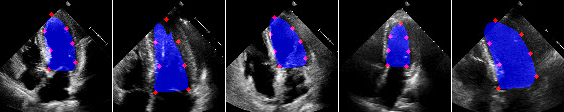

In [16]:
# Mostrar predicciones para datos aleatorios del conjunto de prueba
predictions = []

# Para k número de predicciones
for index in random.choices(range(0, len(test_images)), k=5):

  # Seleccionar la imagen original y convertir a tres canales
  frame = test_images[index]
  frame = np.concatenate([frame, frame, frame], axis=2)

  # Añadir la máscara sobre la imagen original
  mask_prediction = np.squeeze(mask_predictions[index] > 0.5)
  frame[:,:,0] = cv2.addWeighted(mask_prediction.astype(np.float32), 0.75, frame[:,:,0].astype(np.float32), 1, 0)

  # Añadir los puntos de interés sobre la imagen original
  landmarks_prediction = landmark_predictions[index]
  background = np.zeros_like(frame[:,:,0])
  for channel in range(landmarks_prediction.shape[2]):
    landmark = (landmarks_prediction[:,:,channel] >= np.max(landmarks_prediction[:,:,channel]))
    coord = np.unravel_index(np.argmax(landmark), landmark.shape)
    coord = (coord[1], coord[0])
    cv2.circle(background, coord, 2, 255, -1)
  frame[:,:,2] = cv2.addWeighted(background.astype(np.float32), 0.75, frame[:,:,2].astype(np.float32), 1, 0)

  # Añadir la imagen a una lista
  predictions.append(frame * 255)

# Mostrar en una sola línea las imagenes originales con sus predicciones
divider = np.full((img_height, 1, 3), 255)
cv2_imshow(np.concatenate((predictions[0], divider, predictions[1], divider, predictions[2], divider, predictions[3], divider, predictions[4]), axis=1))